In [43]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import periodogram
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

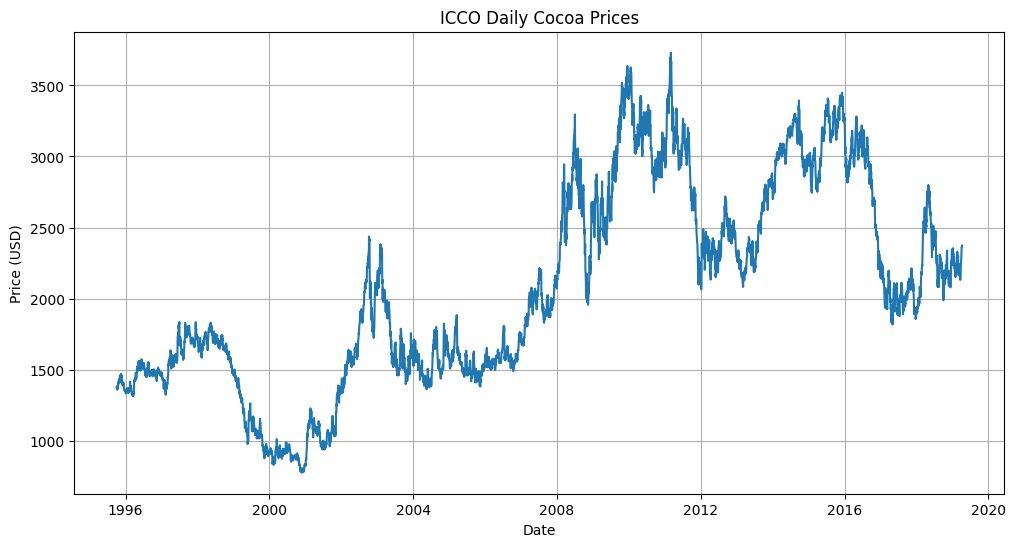

In [26]:
# 1. Load and prepare data
train_df = pd.read_csv('../output/train_df.csv', parse_dates=['Date'], index_col='Date')
valid_df = pd.read_csv('../output/valid_df.csv', parse_dates=['Date'], index_col='Date')
test_df = pd.read_csv('../output/test_df.csv', parse_dates=['Date'], index_col='Date')

series = train_df['icco_daily_price'].dropna()

# 2. Visualize the time series
plt.figure(figsize=(12,6))
plt.plot(series)
plt.title('ICCO Daily Cocoa Prices')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

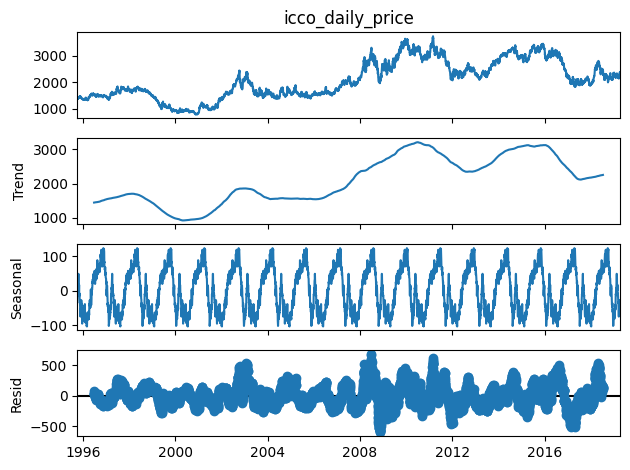

In [27]:
# 3. Decomposition
result = seasonal_decompose(series, model='additive', period=365)
result.plot()
plt.tight_layout()
plt.show()

In [28]:
# 4. Stationarity check
def test_stationarity(timeseries):
    print('ADF Test Results:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {dftest[0]:.4f}')
    print(f'p-value: {dftest[1]:.4f}')
    print('Critical Values:')
    for key, value in dftest[4].items():
        print(f'   {key}: {value:.4f}')
        
test_stationarity(series)

ADF Test Results:
ADF Statistic: -1.9869
p-value: 0.2924
Critical Values:
   1%: -3.4315
   5%: -2.8620
   10%: -2.5670


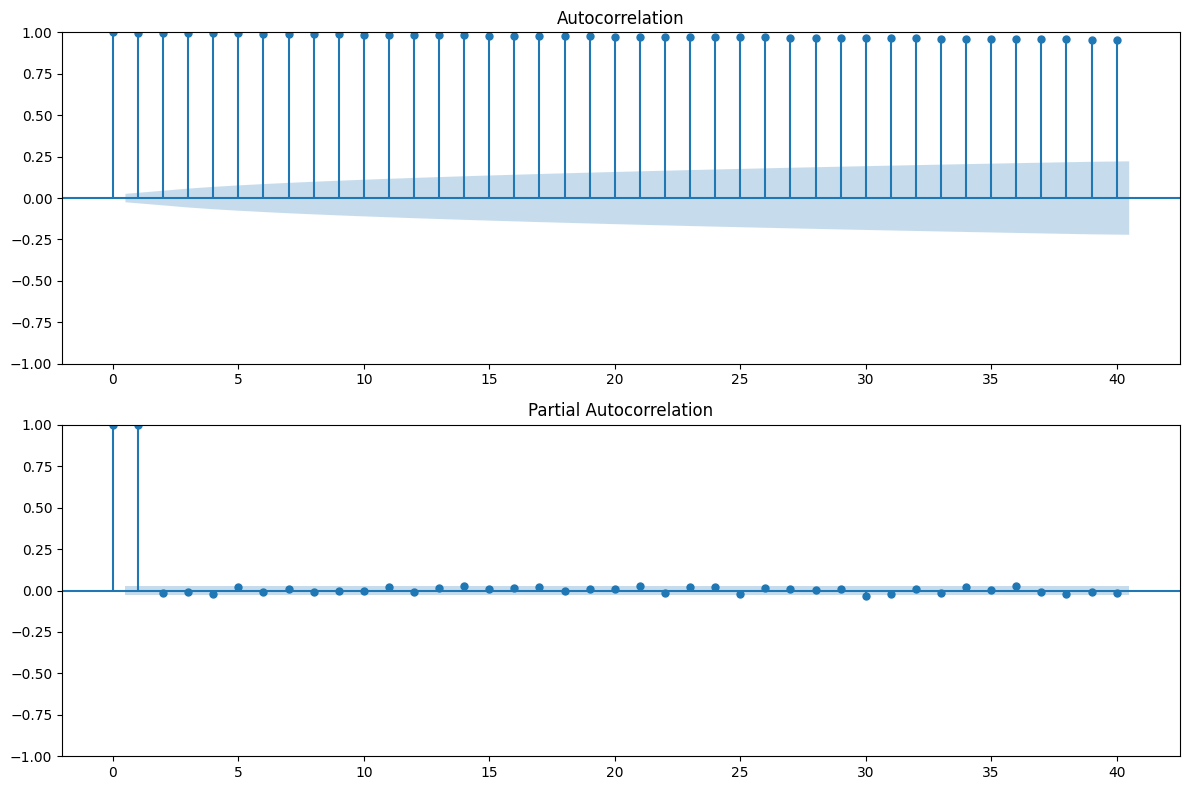

In [29]:
# 5. ACF/PACF plots for ARIMA parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(series, lags=40, ax=ax1)
plot_pacf(series, lags=40, ax=ax2)
plt.tight_layout()
plt.show()

ADF p-value: 0.2924


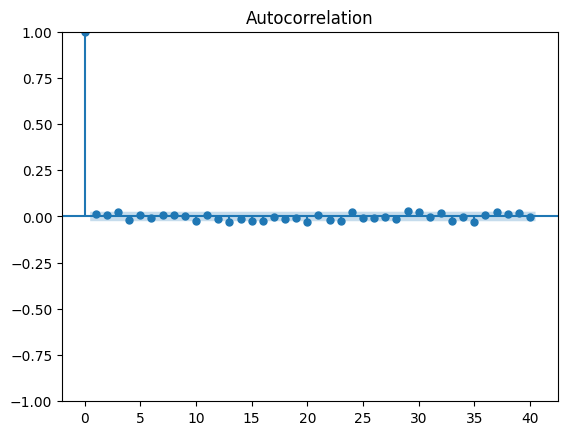

In [30]:
# Test stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(series)
print(f'ADF p-value: {result[1]:.4f}')  # If >0.05, needs differencing

# Apply differencing
diff_series = series.diff().dropna()
plot_acf(diff_series, lags=40)
plt.show()

Differenced ADF p-value: 0.0000


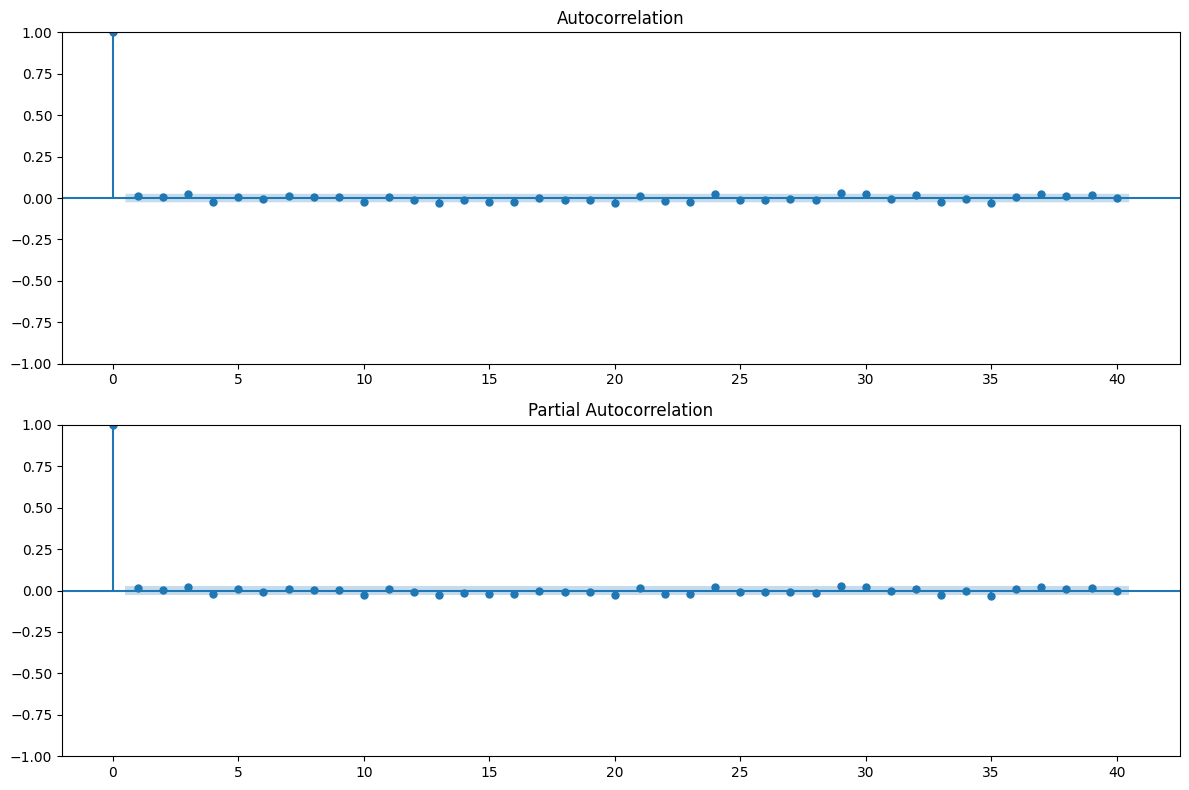

In [31]:
# Verify stationarity
adfuller_result = adfuller(diff_series)
print(f"Differenced ADF p-value: {adfuller_result[1]:.4f}")  # Should be <0.05

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(diff_series, lags=40, ax=ax1)
plot_pacf(diff_series, lags=40, method='ywm', ax=ax2)  # ywm for better estimation
plt.tight_layout()
plt.show()

In [34]:
# Simplest valid ARIMA model
final_model = ARIMA(series, order=(0,1,0))  # Just differencing
results = final_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:       icco_daily_price   No. Observations:                 5890
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -29287.189
Date:                Fri, 28 Mar 2025   AIC                          58576.378
Time:                        14:08:31   BIC                          58583.058
Sample:                             0   HQIC                         58578.700
                               - 5890                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1222.1390     12.528     97.549      0.000    1197.584    1246.694
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):              5039.22
Prob(Q):                              0.24   Pr

c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


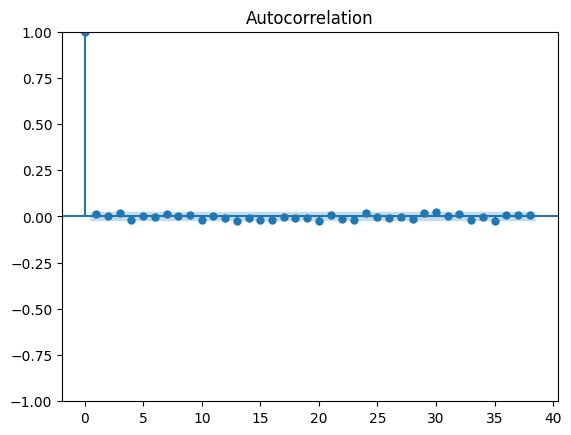

In [35]:
residuals = results.resid
plot_acf(residuals)
plt.show()

In [42]:
# 1. Concatenate just the 'icco_daily_price' column from train_df and valid_df
train_valid_series = pd.concat([
    train_df['icco_daily_price'], 
    valid_df['icco_daily_price']
])

# 2. Fit ARIMA on that single-column series
final_arima = ARIMA(train_valid_series, order=(1,1,1))  
final_arima_fitted = final_arima.fit()
print(final_arima_fitted.summary())

c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       icco_daily_price   No. Observations:                 6626
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -32883.173
Date:                Fri, 28 Mar 2025   AIC                          65772.346
Time:                        15:20:06   BIC                          65792.742
Sample:                             0   HQIC                         65779.394
                               - 6626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4657      0.271      1.719      0.086      -0.065       0.997
ma.L1         -0.4417      0.274     -1.612      0.107      -0.979       0.095
sigma2      1199.8885     11.883    100.972      0.0

The estimated AR(1) and MA(1) coefficients are borderline in terms of statistical significance, suggesting they contribute somewhat to explaining the series’ behavior but may not be strongly predictive.

The intercept (often interpreted as a drift term in a differenced model) is highly significant, implying a steady upward or downward trend over time. However, the diagnostic tests hint that the model’s residuals still contain some structure. In particular, the Ljung-Box test indicates autocorrelation remains in the residuals, and the Jarque-Bera test shows they deviate from normality. These results suggest that while the ARIMA(1,1,1) specification captures some dynamics, there may be room for improvement perhaps by  introducing external variables via a SARIMAX approach.

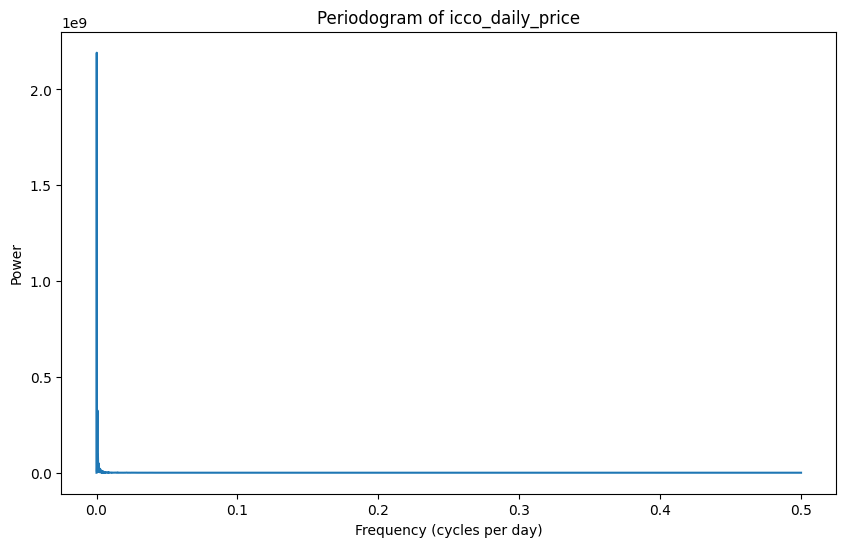

Top dominant frequencies and their corresponding periods:
1. Frequency: 0.0002 cycles per day, Power: 2191453866.3054, Period: 5890.00 days
2. Frequency: 0.0007 cycles per day, Power: 324967856.8515, Period: 1472.50 days
3. Frequency: 0.0005 cycles per day, Power: 94140897.3899, Period: 1963.33 days
4. Frequency: 0.0010 cycles per day, Power: 93185418.5042, Period: 981.67 days
5. Frequency: 0.0015 cycles per day, Power: 48813893.8288, Period: 654.44 days
6. Frequency: 0.0020 cycles per day, Power: 23075605.8881, Period: 490.83 days
7. Frequency: 0.0012 cycles per day, Power: 22614259.5018, Period: 841.43 days
8. Frequency: 0.0027 cycles per day, Power: 17807044.5745, Period: 368.12 days
9. Frequency: 0.0029 cycles per day, Power: 14233914.9525, Period: 346.47 days
10. Frequency: 0.0017 cycles per day, Power: 13088995.6196, Period: 589.00 days


In [37]:
# Extract the time series (make sure it's evenly spaced)
ts = train_df['icco_daily_price']

# Compute the periodogram with a sampling frequency of 1 (daily observations)
freqs, power = periodogram(ts, fs=1)

# Plot the periodogram for visual inspection
plt.figure(figsize=(10, 6))
plt.plot(freqs, power)
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Power')
plt.title('Periodogram of icco_daily_price')
plt.show()

# Exclude the zero-frequency component
nonzero_idxs = np.where(freqs > 0)
nonzero_freqs = freqs[nonzero_idxs]
nonzero_power = power[nonzero_idxs]

# Sort the non-zero frequencies by power in descending order
sorted_indices = np.argsort(nonzero_power)[::-1]

# Choose the number of top frequencies to display (e.g., top 5)
top_n = 10
top_freqs = nonzero_freqs[sorted_indices][:top_n]
top_power = nonzero_power[sorted_indices][:top_n]

print("Top dominant frequencies and their corresponding periods:")
for i, (f, pwr) in enumerate(zip(top_freqs, top_power), start=1):
    period = 1 / f if f != 0 else np.inf
    print(f"{i}. Frequency: {f:.4f} cycles per day, Power: {pwr:.4f}, Period: {period:.2f} days")

c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       icco_daily_price   No. Observations:                 5890
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -29273.108
Date:                Fri, 28 Mar 2025   AIC                          58564.216
Time:                        14:08:42   BIC                          58624.341
Sample:                             0   HQIC                         58585.115
                               - 5890                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1        -64.3794     37.965     -1.696      0.090    -138.789      10.030
cos_1        -32.9291     39.394     -0.836      0.403    -110.139      44.281
sin_2         16.0617     19.157      0.838      0.4

c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


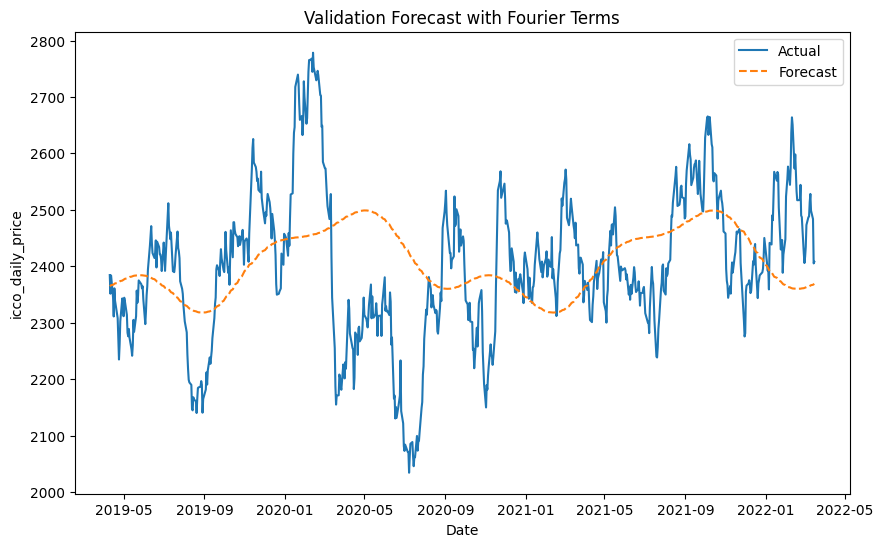

In [38]:
# Ensure that your DataFrames have a proper DateTimeIndex
train_df.index = pd.to_datetime(train_df.index)
valid_df.index = pd.to_datetime(valid_df.index)
test_df.index = pd.to_datetime(test_df.index)

# Define a function to generate Fourier terms
def create_fourier_terms(index, period, K):
    """
    Create Fourier terms for a given datetime index.
    
    Parameters:
      index : pandas.DatetimeIndex - index of the series
      period : int - seasonal period (e.g., 365 for annual seasonality in daily data)
      K : int - number of Fourier pairs
      
    Returns:
      DataFrame with columns sin_1, cos_1, sin_2, cos_2, ... for the given index.
    """
    t = np.arange(len(index))
    terms = {}
    for k in range(1, K + 1):
        terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(terms, index=index)

# Set the seasonal period (365 days for one year) and number of Fourier pairs
seasonal_period = 365
K = 3  # You can adjust K based on your data and model performance

# Generate Fourier terms for each dataset
fourier_train = create_fourier_terms(train_df.index, seasonal_period, K)
fourier_valid = create_fourier_terms(valid_df.index, seasonal_period, K)
fourier_test  = create_fourier_terms(test_df.index, seasonal_period, K)

# Define your target series from the DataFrames
train_series = train_df['icco_daily_price']
valid_series = valid_df['icco_daily_price']
test_series  = test_df['icco_daily_price']

# Fit a SARIMAX model with Fourier terms as exogenous regressors.
# Here we use an ARIMA order of (1, 1, 1) for demonstration purposes.
model = SARIMAX(
    train_series, 
    order=(1, 1, 1), 
    exog=fourier_train,
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit()
print(fitted_model.summary())

# Forecast on the validation period.
# Make sure to pass the corresponding Fourier terms for the forecast horizon.
steps = len(valid_series)
forecast_valid = fitted_model.forecast(steps=steps, exog=fourier_valid)

# Evaluate the forecast performance on the validation set using RMSE.
val_mse = mean_squared_error(valid_series, forecast_valid)
val_rmse = np.sqrt(val_mse)
print(f"Validation RMSE: {val_rmse:.2f}")

# Plot actual vs forecasted values for the validation period.
plt.figure(figsize=(10, 6))
plt.plot(valid_series.index, valid_series, label='Actual')
plt.plot(valid_series.index, forecast_valid, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('icco_daily_price')
plt.title('Validation Forecast with Fourier Terms')
plt.legend()
plt.show()


c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       icco_daily_price   No. Observations:                 5890
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -29131.944
Date:                Fri, 28 Mar 2025   AIC                          58287.889
Time:                        15:29:55   BIC                          58368.055
Sample:                             0   HQIC                         58315.755
                               - 5890                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ghs_to_usd     34.4872     54.015      0.638      0.523     -71.381     140.355
oil_price       5.0176      0.257     19.538      0.000       4.514       5.521
sp500_price     0.1675      0.027      6.097    

c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


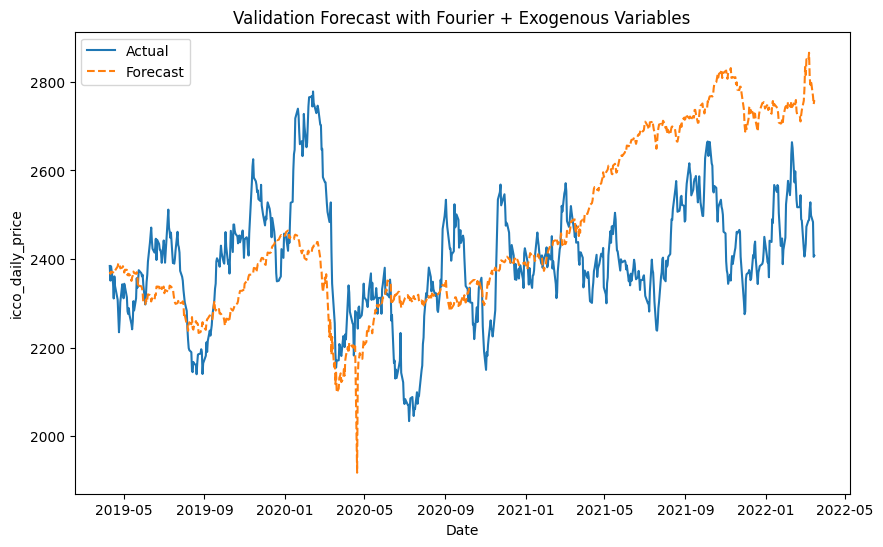

c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test RMSE: 3541.67


c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [44]:
K = 3  # try 3 pairs to start
fourier_train = create_fourier_terms(train_df.index, 365, K)
fourier_valid = create_fourier_terms(valid_df.index, 365, K)
fourier_test  = create_fourier_terms(test_df.index, 365, K)

#------------------------------------------------
#    Prepare the exogenous data
#    Combine your existing columns with the
#    Fourier terms
#------------------------------------------------
# Existing exogenous features
train_exog = train_df[['ghs_to_usd', 'oil_price', 'sp500_price']]
valid_exog = valid_df[['ghs_to_usd', 'oil_price', 'sp500_price']]
test_exog  = test_df[['ghs_to_usd', 'oil_price', 'sp500_price']]

# Add Fourier terms to each set of exogenous variables
train_exog = pd.concat([train_exog, fourier_train], axis=1)
valid_exog = pd.concat([valid_exog, fourier_valid], axis=1)
test_exog  = pd.concat([test_exog,  fourier_test],  axis=1)

#------------------------------------------------
#    Define your target series
#------------------------------------------------
train_y = train_df['icco_daily_price']
valid_y = valid_df['icco_daily_price']
test_y  = test_df['icco_daily_price']

#------------------------------------------------
#    Fit the SARIMAX model on training data
#    Choose your ARIMA orders. We'll do (1,1,1)
#    as a simple starting point
#------------------------------------------------
model_exog = SARIMAX(
    train_y,
    order=(1, 1, 1),
    exog=train_exog,
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_model_exog = model_exog.fit()
print(fitted_model_exog.summary())

#------------------------------------------------
#    Forecast on the validation set
#------------------------------------------------
val_forecast_exog = fitted_model_exog.forecast(
    steps=len(valid_df),
    exog=valid_exog
)

# Evaluate forecast performance
val_mse = mean_squared_error(valid_y, val_forecast)
val_rmse = np.sqrt(val_mse)
print(f"Validation RMSE: {val_rmse:.2f}")

# Plot validation results
plt.figure(figsize=(10, 6))
plt.plot(valid_y.index, valid_y, label='Actual')
plt.plot(valid_y.index, val_forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('icco_daily_price')
plt.title('Validation Forecast with Fourier + Exogenous Variables')
plt.legend()
plt.show()

#------------------------------------------------
#    (Optional) Refit on train+valid, forecast test
#------------------------------------------------
# Combine train+valid for final model
train_valid_y = pd.concat([train_y, valid_y])
train_valid_exog = pd.concat([train_exog, valid_exog])

final_model = SARIMAX(
    train_valid_y,
    order=(1, 1, 1),
    exog=train_valid_exog,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Forecast test set
test_forecast = final_model.forecast(
    steps=len(test_df),
    exog=test_exog
)

# Evaluate on test set
test_mse = mean_squared_error(test_y, test_forecast)
test_rmse = np.sqrt(test_mse)
print(f"Test RMSE: {test_rmse:.2f}")

In [ ]:
def compute_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    rmsle = mean_squared_error(np.log1p(y_true), np.log1p(y_pred), squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = r2_score(y_true, y_pred)
    return [rmse, rmsle, mape, r2]

In [41]:
import pandas as pd
from prophet import Prophet

# 1. Copy the original DataFrame so we don't overwrite it
train_prophet = train_df.copy()

# 2. Create a 'ds' column from the current index
train_prophet['ds'] = train_prophet.index

# 3. Rename 'icco_daily_price' to 'y'
train_prophet.rename(columns={'icco_daily_price': 'y'}, inplace=True)

# 4. Keep only the columns Prophet needs:
#    ds, y, plus any regressors (ghs_to_usd, oil_price, sp500_price)
train_prophet = train_prophet[['ds', 'y', 'ghs_to_usd', 'oil_price', 'sp500_price']]

# 5. Ensure ds is a datetime type (it probably already is, but just to be safe)
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])

# 6. Initialize Prophet and add regressors
m = Prophet()
m.add_regressor('oil_price')
m.add_regressor('sp500_price')

# 7. Fit the model
m.fit(train_prophet)

# 1. Make a future dataframe that covers the validation period
future = m.make_future_dataframe(periods=len(valid_df), freq='D')

# 2. Merge in the actual known regressors from valid_df
valid_regressors = valid_df.reset_index().rename(columns={'Date': 'ds'})
valid_regressors = valid_regressors[['ds', 'oil_price', 'sp500_price']]

future = future.merge(valid_regressors, on='ds', how='left')

print(future.head(30))      # Inspect the first rows
print(future.tail(30))      # Inspect the last rows
print(future.isna().sum())  # Check how many NaNs per column

# Now no NaNs remain in these columns
forecast = m.predict(future)



14:11:20 - cmdstanpy - INFO - Chain [1] start processing
14:11:21 - cmdstanpy - INFO - Chain [1] done processing


           ds  oil_price  sp500_price
0  1995-10-03        NaN          NaN
1  1995-10-04        NaN          NaN
2  1995-10-05        NaN          NaN
3  1995-10-06        NaN          NaN
4  1995-10-09        NaN          NaN
5  1995-10-10        NaN          NaN
6  1995-10-11        NaN          NaN
7  1995-10-12        NaN          NaN
8  1995-10-13        NaN          NaN
9  1995-10-16        NaN          NaN
10 1995-10-17        NaN          NaN
11 1995-10-18        NaN          NaN
12 1995-10-19        NaN          NaN
13 1995-10-20        NaN          NaN
14 1995-10-23        NaN          NaN
15 1995-10-24        NaN          NaN
16 1995-10-25        NaN          NaN
17 1995-10-26        NaN          NaN
18 1995-10-27        NaN          NaN
19 1995-10-30        NaN          NaN
20 1995-10-31        NaN          NaN
21 1995-11-01        NaN          NaN
22 1995-11-02        NaN          NaN
23 1995-11-03        NaN          NaN
24 1995-11-06        NaN          NaN
25 1995-11-0

ValueError: Found NaN in column 'oil_price'